<a href="https://colab.research.google.com/github/susie682/Infosys722--Assignment-4-BDAS/blob/main/2_4_1_MissValuesProcess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Quality – Chicago Crime (2017): Figures 12–16

This notebook produces the visuals and tables for **Section 2.4**:
- **Figure 12**: Missingness heatmap (sampled rows)
- **Figure 13**: Missing values by field (bar chart)
- **Figure 14**: Boxplot of Hour
- **Figure 15**: Boxplot of Latitude
- **Figure 16**: Boxplot of Longitude
- **Table 3**: IQR outlier detection summary

Environment: **Google Colab + PySpark 3.5.1**.
Data: `CrimeData_2017.csv` on Google Drive (Kaggle Chicago Crime 2017 subset).


In [2]:
# =============================
# 0) Setup (Colab + PySpark)
# =============================
!pip -q install pyspark==3.5.1

from google.colab import drive
drive.mount('/content/drive')  # Authorize access to your Drive

from pyspark.sql import SparkSession, functions as F, types as T
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# Create Spark session
spark = SparkSession.builder.appName('ChicagoCrime2017_DataQuality').getOrCreate()

# === Path to your CSV on Google Drive ===
FILE_PATH = '/content/drive/MyDrive/Infosys 722/CrimeData_2017.csv'  # <-- change if needed

# Read CSV with header and schema inference
df = (spark.read
      .option('header', True)
      .option('inferSchema', True)
      .csv(FILE_PATH))

print('Columns:', df.columns)
print('Row count (all years):', df.count())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Columns: ['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type', 'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat', 'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate', 'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude', 'Location']
Row count (all years): 267562


In [3]:
# =============================
# 1) Timestamp parsing & fields
# =============================
COL_DATE = 'Date' if 'Date' in df.columns else 'ReportedDate'
COL_CAT  = 'Primary Type' if 'Primary Type' in df.columns else ('PrimaryType' if 'PrimaryType' in df.columns else 'Primary_Type')
COL_LAT  = 'Latitude' if 'Latitude' in df.columns else 'latitude'
COL_LON  = 'Longitude' if 'Longitude' in df.columns else 'longitude'
COL_DIST = 'District' if 'District' in df.columns else 'district'
COL_WARD = 'Ward' if 'Ward' in df.columns else 'ward'
COL_COMM = 'Community Area' if 'Community Area' in df.columns else ('CommunityArea' if 'CommunityArea' in df.columns else 'community_area')
COL_BEAT = 'Beat' if 'Beat' in df.columns else 'beat'

ts1 = F.to_timestamp(F.col(COL_DATE), 'MM/dd/yyyy hh:mm:ss a')
ts2 = F.to_timestamp(F.col(COL_DATE), 'MM/dd/yyyy HH:mm:ss')
df = df.withColumn('ts', F.coalesce(ts1, ts2))

for bcol in ['Arrest', 'Domestic']:
  if bcol in df.columns:
    df = df.withColumn(bcol, F.col(bcol).cast(T.BooleanType()))

df = (
  df.withColumn('Year',  F.year('ts'))
    .withColumn('Month', F.month('ts'))
    .withColumn('Hour',  F.hour('ts'))
    .withColumn('WeekdayNum', F.dayofweek('ts'))
    .withColumn(
        'Weekday',
        F.when(F.col('WeekdayNum')==2, 'Monday')
         .when(F.col('WeekdayNum')==3, 'Tuesday')
         .when(F.col('WeekdayNum')==4, 'Wednesday')
         .when(F.col('WeekdayNum')==5, 'Thursday')
         .when(F.col('WeekdayNum')==6, 'Friday')
         .when(F.col('WeekdayNum')==7, 'Saturday')
         .when(F.col('WeekdayNum')==1, 'Sunday')
         .otherwise('Unknown')
    )
)

df2017 = df.filter(F.col('Year')==2017)
print('Row count (2017):', df2017.count())


Row count (2017): 267562


In [5]:
# =============================
# 2) Output directory & styling
# =============================
os.makedirs('/content/figs', exist_ok=True)
plt.rcParams.update({'figure.dpi': 150})


            field  missing_pct
0        Latitude     1.543567
1       Longitude     1.543567
2            Ward     0.000374
3        District     0.000374
4  Community Area     0.000000
5            Beat     0.000000
6            Date     0.000000
7            Hour     0.000000
8           Month     0.000000
9         Weekday     0.000000


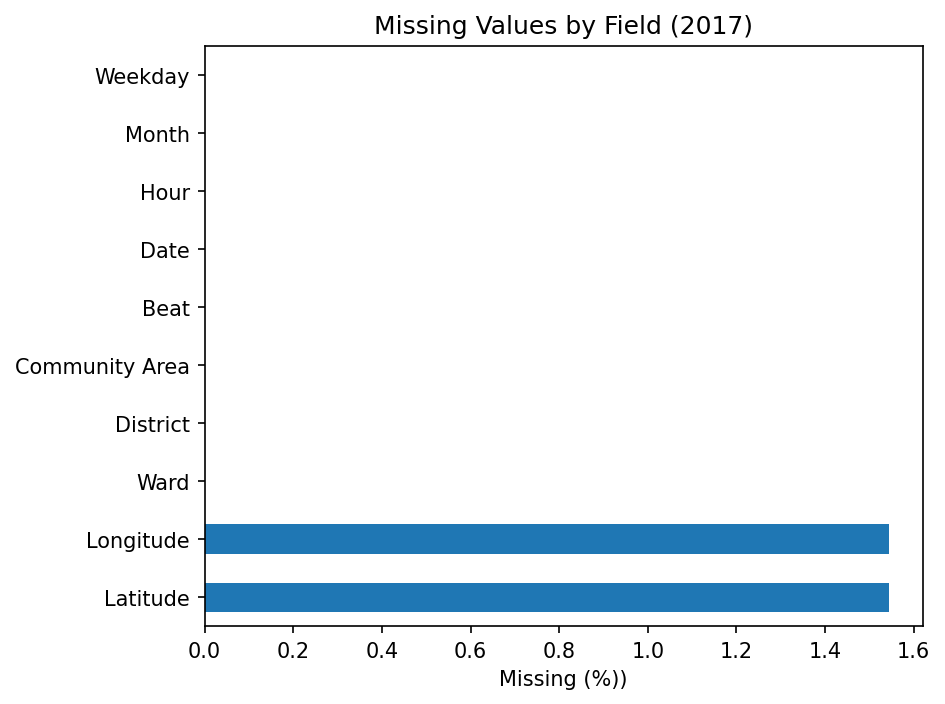

In [6]:
# =========================================
# 3) Field-level missingness (Figure 13)
# =========================================
audit_cols = [c for c in [
    COL_LAT, COL_LON, COL_WARD, COL_DIST, COL_COMM, COL_BEAT,
    COL_DATE, 'Hour', 'Month', 'Weekday'
] if c in df2017.columns]

total_rows = df2017.count()
missing_perc = []
for c in audit_cols:
  n_miss = df2017.filter(F.col(c).isNull()).count()
  missing_perc.append((c, 100.0 * n_miss / max(total_rows, 1)))

miss_pd = pd.DataFrame(missing_perc, columns=['field', 'missing_pct']).sort_values('missing_pct', ascending=False)
print(miss_pd)

ax = miss_pd.plot(kind='barh', x='field', y='missing_pct', legend=False)
ax.set_title('Missing Values by Field (2017)')
ax.set_xlabel('Missing (%))')
ax.set_ylabel('')
plt.tight_layout()
plt.savefig('/content/figs/figure13_missing_by_field.png')
plt.show()


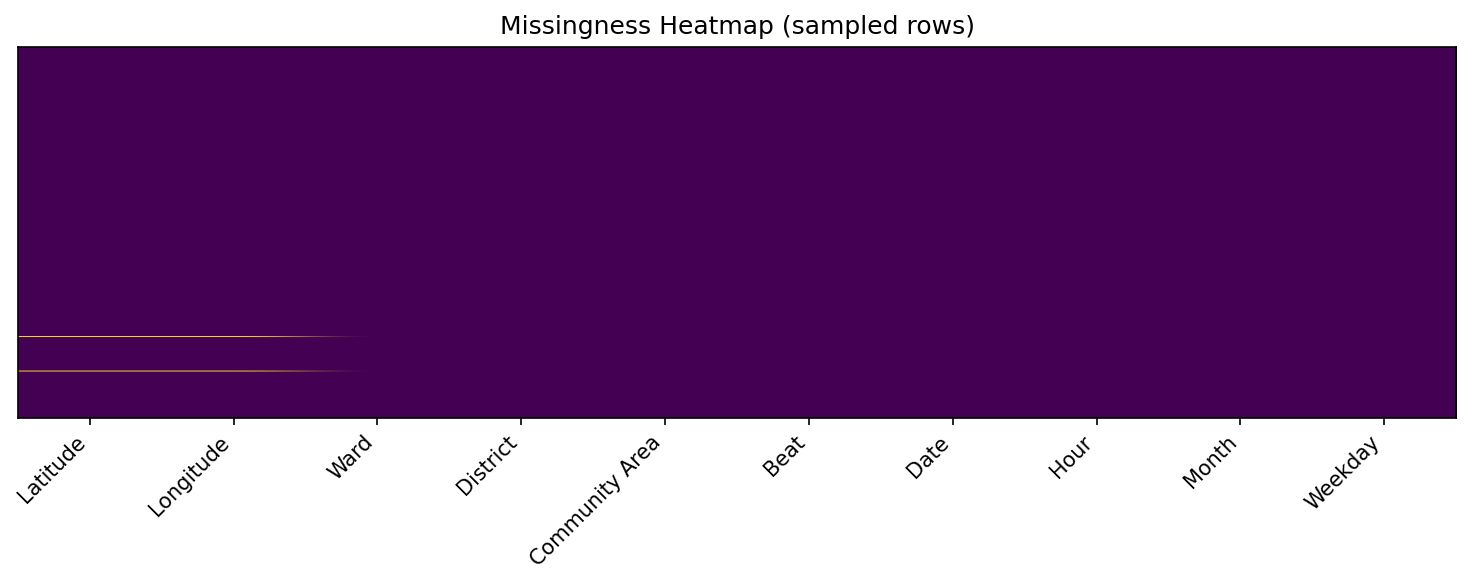

In [7]:
# ==============================================
# 4) Missingness heatmap on sampled rows (Fig 12)
# ==============================================
sample_n = 400
sample_df = df2017.select(*audit_cols).orderBy(F.rand(42)).limit(sample_n).toPandas()
mask = sample_df.isna().astype(int).values
plt.figure(figsize=(10, 4))
plt.imshow(mask, aspect='auto')  # do not set a specific colormap
plt.title('Missingness Heatmap (sampled rows)')
plt.yticks([])
plt.xticks(range(len(audit_cols)), audit_cols, rotation=45, ha='right')
plt.tight_layout()
plt.savefig('/content/figs/figure12_missingness_heatmap.png')
plt.show()


In [8]:
# =========================================
# 5) IQR outlier detection (Table 3)
# =========================================
iqr_fields = []
if COL_LAT in df2017.columns:
  iqr_fields.append(COL_LAT)
if COL_LON in df2017.columns:
  iqr_fields.append(COL_LON)
iqr_fields += [c for c in ['Month','Hour'] if c in df2017.columns]

rows = []
for feat in iqr_fields:
  q1, q3 = df2017.approxQuantile(feat, [0.25, 0.75], 0.01)
  iqr = q3 - q1
  lower = q1 - 1.5 * iqr
  upper = q3 + 1.5 * iqr
  n_out = df2017.filter((F.col(feat) < lower) | (F.col(feat) > upper)).count()
  rows.append({'feature': feat, 'q1': q1, 'q3': q3, 'iqr': iqr, 'lower': lower, 'upper': upper, 'n_outliers': n_out})

iqr_pd = pd.DataFrame(rows)
print(iqr_pd)
iqr_pd.to_csv('/content/drive/MyDrive/Infosys 722/table3_iqr_outliers.csv', index=False)


     feature         q1         q3       iqr      lower      upper  n_outliers
0   Latitude  41.768185  41.904538  0.136353  41.563655  42.109068           0
1  Longitude -87.713490 -87.627760  0.085729 -87.842084 -87.499166        1385
2      Month   4.000000   9.000000  5.000000  -3.500000  16.500000           0
3       Hour   9.000000  18.000000  9.000000  -4.500000  31.500000           0


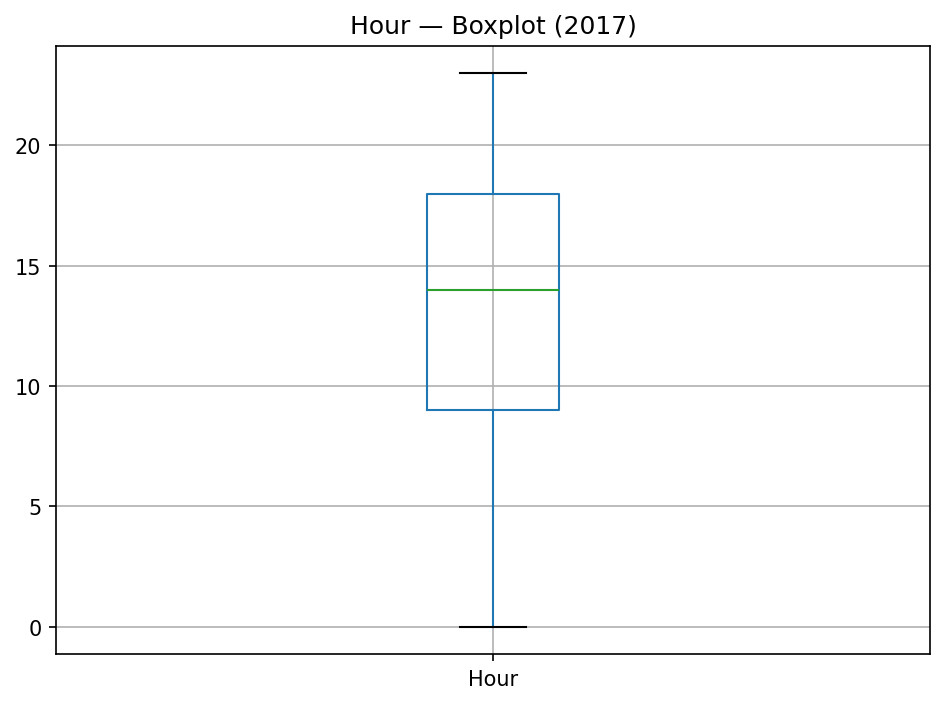

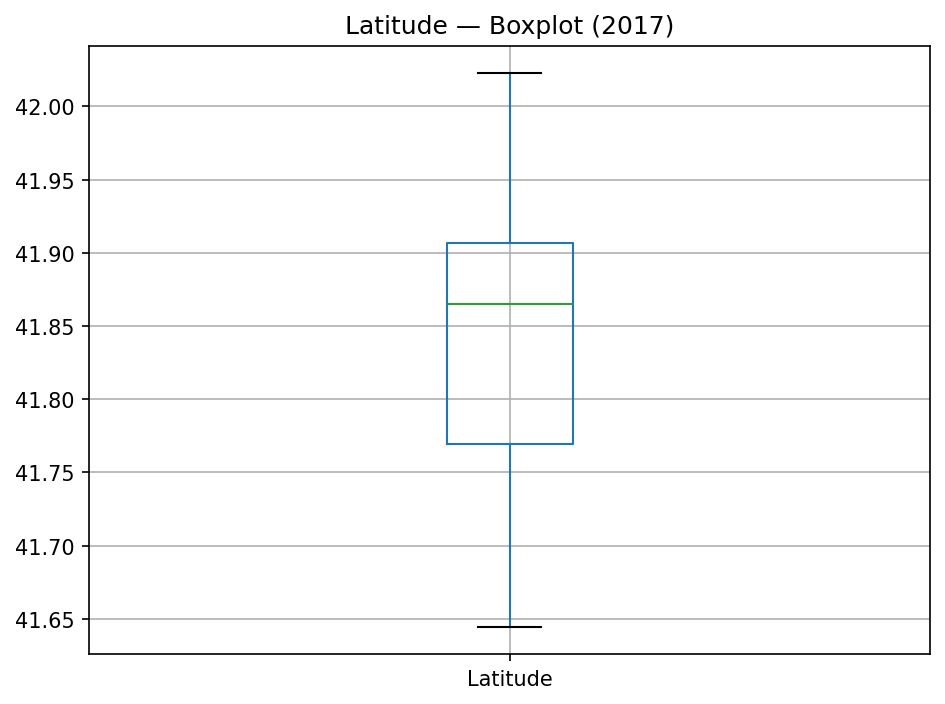

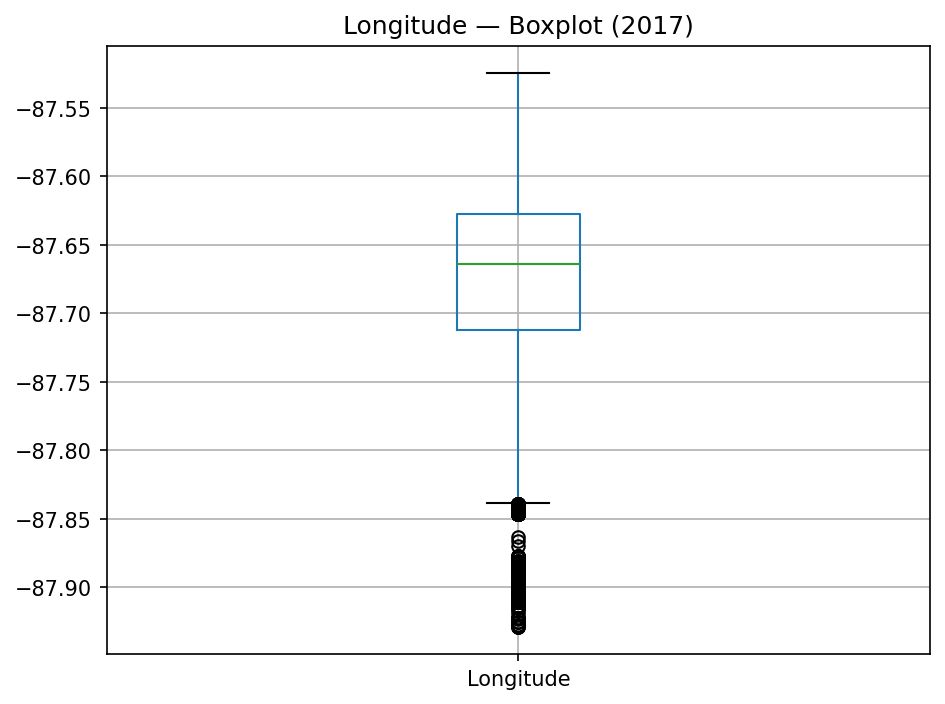

In [10]:
# =========================================
# 6) Boxplots (Figures 14–16)
# =========================================
pd_cols = [c for c in ['Hour','Month', COL_LAT, COL_LON] if c in df2017.columns]
plot_pd = df2017.select(*pd_cols).toPandas()

plt.figure()
plot_pd[['Hour']].boxplot()
plt.title('Hour — Boxplot (2017)')
plt.xlabel('')
plt.tight_layout()
plt.savefig('/content/figs/figure14_box_hour.png')
plt.show()

if COL_LAT in plot_pd.columns:
  plt.figure()
  plot_pd[[COL_LAT]].boxplot()
  plt.title('Latitude — Boxplot (2017)')
  plt.xlabel('')
  plt.tight_layout()
  plt.savefig('/content/figs/figure15_box_latitude.png')
  plt.show()

if COL_LON in plot_pd.columns:
  plt.figure()
  plot_pd[[COL_LON]].boxplot()
  plt.title('Longitude — Boxplot (2017)')
  plt.xlabel('')
  plt.tight_layout()
  plt.savefig('/content/figs/figure16_box_longitude.png')
  plt.show()


In [11]:
# =============================
# 7) Output recap
# =============================
import glob, pprint
files = sorted(glob.glob('/content/figs/*'))
print('Generated files in /content/figs/:')
pprint.pp(files)


Generated files in /content/figs/:
['/content/figs/figure12_missingness_heatmap.png',
 '/content/figs/figure13_missing_by_field.png',
 '/content/figs/figure14_box_hour.png',
 '/content/figs/figure15_box_latitude.png',
 '/content/figs/figure16_box_longitude.png',
 '/content/figs/table3_iqr_outliers.csv']
